In [ ]:
%%capture
!pip install pykan
!pip install Bio
!pip install pybedtools
# !pip install torchtext==0.16.0

In [ ]:
%%capture
!pip install git+https://github.com/ML-Bioinfo-CEITEC/genomic_benchmarks.git

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import numpy as np

In [ ]:
import kan
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import torch
import itertools
from tqdm.auto import tqdm
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import pybedtools
from sklearn.model_selection import train_test_split

In [ ]:
import random

In [ ]:
dtype = torch.get_default_dtype()

#Preproc

In [ ]:
pd.read_csv("/content/high_levels_dataset.csv")

,sequence,label,split
0,CCCCGGGCCTCAGCTCCACCCCATGCAGCAAACTTAATACCC,1,test
1,GGGCGCCCTGGGGCGAGGGAGCGGGG,1,train
2,CATGATCTATACGCTGTTTGGATACCCATAGGGCT,0,train
3,GGGGGCACTGGCCGCGGGGGTGCCGGGATGGGGATGGAGGG,1,train
4,GGGGTGGGGTGCAGGAGCCGTGGGG,1,train
...,...,...,...
280527,AAAAATGATAAAGAGCTGACTGCGTCCCGACATATC,0,train
280528,GGGGCTGGCAGGCGCAGGGGCTGCGGCTGGG,1,train
280529,GGAGGTCAGGGGGCCCCTGGGTGGGAGTGGGG,1,train
280530,CCTCCCTACCCCCAACCTTCTCCCTTTTTCAGCACCGCTGGCCGGACCC,1,train


In [ ]:
def rename_col_by_index(dataframe, index_mapping):
    dataframe.columns = [index_mapping.get(i, col) for i, col in enumerate(dataframe.columns)]
    return dataframe

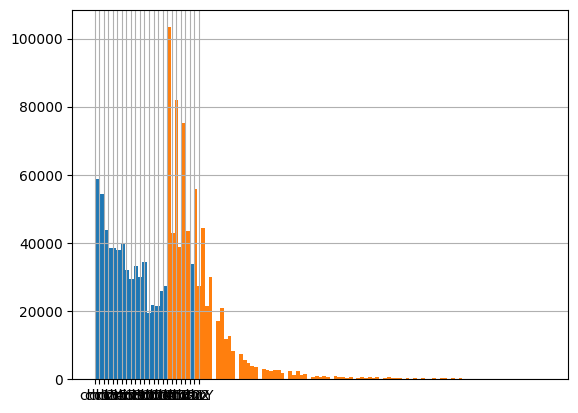

In [ ]:
pos_df = pd.read_csv('/content/H-DNA.bed',
 sep='\t', comment='t', header=None)
# new_column_mapping = {0: 'chrom', 1: 'chromStart', 2: "chromEnd", 3: "erf" , 4: "fe" , 5: "df"}
# pos_df = rename_col_by_index(pos_df, new_column_mapping)
# pos_df = pos_df.drop(columns=["erf", "fe", "df"])
header = ['chrom', 'chromStart', 'chromEnd']
pos_df.columns = header[:len(pos_df.columns)]
pos_df['len'] = pos_df.chromEnd - pos_df.chromStart
pos_df.head()
plt.hist(pos_df.chrom, bins=len(pos_df.chrom.unique()))
pos_df.len.quantile(0.5)
pos_df.len[pos_df.len > 512].count()
pos_df.len[pos_df.len <= 512].count() / pos_df.len.count()
pos_df.len.hist(bins=100)
# Filtration
quad_len = 512
pos_df_filter = pos_df[pos_df.len
 <= quad_len].copy().reset_index(drop=True)
pos_df_filter.len.max()
pos_df_filter['add_len'] = quad_len - pos_df_filter.len
pos_df_filter['left_add_len'] = (pos_df_filter.add_len
 / 2).astype('int64')
pos_df_filter['right_add_len'] = pos_df_filter.add_len \
 - pos_df_filter.left_add_len
pos_df_filter['new_chromStart'] = pos_df_filter.chromStart \
 - pos_df_filter.left_add_len
pos_df_filter['new_chromEnd'] = pos_df_filter.chromEnd \
 + pos_df_filter.right_add_len
pos_df_filter['new_len'] = pos_df_filter.new_chromEnd \
 - pos_df_filter.new_chromStart
pos_df_filter.head()
# Save data
pos_df_filter[['chrom', 'new_chromStart', 'new_chromEnd'
 ]].to_csv('G4_Chip_seq_filter_norm_to_500.bed', sep='\t',
 header=None, index=None)

In [ ]:
df = pd.read_csv('/content/G4_Chip_seq_filter_norm_to_500.bed',
 sep='\t', comment='t', header=None)
header = ['chrom', 'chromStart', 'chromEnd']
df.columns = header[:len(df.columns)]

In [ ]:
df.to_csv('HDNA_to_500.bed', sep='\t', index=False, header=False)

In [ ]:
df = pd.read_csv('Endoquad_to_500.bed',
 sep='\t', comment='t', header=None)

In [ ]:
df

,chrom,chromStart,chromEnd
0,chr1,27296,27808
1,chr1,30624,31136
2,chr1,30686,31198
3,chr1,31470,31982
4,chr1,33275,33787
...,...,...,...
704826,chrY,59327058,59327570
704827,chrY,59329202,59329714
704828,chrY,59346904,59347416
704829,chrY,59348287,59348799


# Vanilla KAN

In [ ]:
import pandas as pd
import numpy as np
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from collections import defaultdict
import matplotlib.pyplot as plt
import pybedtools
from sklearn.model_selection import train_test_split

In [ ]:
%%capture
!pip install git+https://github.com/ML-Bioinfo-CEITEC/genomic_benchmarks.git

In [ ]:
from genomic_benchmarks.data_check import list_datasets

In [ ]:
from genomic_benchmarks.loc2seq import download_dataset

In [ ]:
from genomic_benchmarks.dataset_getters.pytorch_datasets import HumanNontataPromoters

In [ ]:
dset = HumanNontataPromoters(split='train', version=0)

Downloading...
From (original): https://drive.google.com/uc?id=1VdUg0Zu8yfLS6QesBXwGz1PIQrTW3Ze4
From (redirected): https://drive.google.com/uc?id=1VdUg0Zu8yfLS6QesBXwGz1PIQrTW3Ze4&confirm=t&uuid=3c0b248d-da81-418b-8ce9-83cdcf431618
To: /root/.genomic_benchmarks/human_nontata_promoters.zip
100%|██████████| 11.8M/11.8M [00:00<00:00, 24.6MB/s]


In [ ]:
dset[0][0]

'TGCAGGGGTCGCCCTGGGAGCGCGGCCCGCCTCCTTCTGCCCGGCCCCCACCCCCCGGCCCCGCCTTTCTCCCATTCGGCCCCCTCCCCGCCGGGTCCCTCCAGCCTTCCCTCGCGCAGCCGCTGCCAAAGCCTGGAGAAGTGGAATCTCGTCAGCGCCGCTCCCTGCGCGGGACTCGCGGAACGGCACTGAGCATGCTCAGTTGCCGGAGCCCGTTCTGGTCTCAAGTAGGAAGCTAGTGCGCTGTAACC'

In [ ]:
sequences = []
# chromosomes = []

In [ ]:
def fasta_to_csv(fasta_file):
    for record in SeqIO.parse(fasta_file, "fasta"):
        sequences.append(str(record.seq).upper())
        sequence = str(record.seq).upper()
        # chrom_info = record.id.split('_')[0]
        # chromosome = chrom_info if chrom_info.startswith("chr") else "chr" + chrom_info
        # chromosomes.append(chromosome)

In [ ]:
fasta_to_csv("/content/HDNA_500.fasta")

In [ ]:
raw_dataset = pd.DataFrame({"sequence": sequences, "label": 1, "split": "train"})
raw_dataset.head()

,sequence,label,split
0,TGGTAGCCACCAGGCACATGCAGCCACTGAGCACTTGAAATGTGGA...,1,train
1,GCCACTGTCTCGCTGGCTGCAGCGTGTGGTCCCCTTACCAGAGGTA...,1,train
2,CCACTCATGTTGTAGACAGAATGTTTATGTCCTCTCCAAATGCTTA...,1,train
3,ACTTTGGTAGGCTGACGCGAGAGGACTGCTTGAGCCCAAGAGTTTG...,1,train
4,AAGGGGAGGGGAGAATGGGAAGTGGCTGCTTCATGGGTACAAGGTT...,1,train


In [ ]:
min_length = raw_dataset['sequence'].apply(len).min()
max_length = raw_dataset['sequence'].apply(len).max()

In [ ]:
def generate_random_sequence(length):
    return ''.join(np.random.choice(['A', 'T', 'C', 'G'], size=length))

num_random_sequences = len(raw_dataset)

random_data = pd.DataFrame({
    'sequence': [
        generate_random_sequence(np.random.randint(min_length, max_length + 1))
        for _ in range(num_random_sequences)
    ],
    'label': [0] * num_random_sequences,
    'split': ['train'] * num_random_sequences
})

In [ ]:
def generate_random_sequence(length=512):
    return ''.join(np.random.choice(['A', 'T', 'C', 'G'], size=length))

num_random_sequences = len(raw_dataset)

random_data = pd.DataFrame({
    'sequence': [generate_random_sequence(512) for _ in range(num_random_sequences)],
    'label': [0] * num_random_sequences,
    'split': ['train'] * num_random_sequences
})

data = pd.concat([raw_dataset, random_data], ignore_index=True)

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42, stratify=data['label'])
train_data['split'] = 'train'
test_data['split'] = 'test'

final_data = pd.concat([train_data, test_data], ignore_index=True)

In [ ]:
aa_list = 'ATCG'

def one_hot_encode(sequence):
    """
    One-hot encodes a sequence.

    Args:
        sequence (str): The input sequence.

    Returns:
        numpy.array: The one-hot encoded representation of the sequence.
    """
    aa_to_index = {aa: i for i, aa in enumerate(aa_list)}

    encoding = np.zeros((len(sequence), len(aa_list)))

    for i, aa in enumerate(sequence):
        if aa in aa_to_index:
            encoding[i, aa_to_index[aa]] = 1
        else:
            encoding[i, -1] = 1

    return encoding


def generate_sample_dataset(df, sample_fraction=0.05):
    """
    Generate a dataset with one-hot encoded sequences, padded to a fixed length,
    using only a sample of the original dataset while maintaining the train-test split ratio.

    Args:
        df (pd.DataFrame): The input dataframe.
        sample_fraction (float): The fraction of the dataset to use (default is 0.2).

    Returns:
        dict: A dictionary containing train_input, test_input, train_label, and test_label.
    """
    sampled_df = df.sample(frac=sample_fraction, random_state=42)

    dataset = {'train_input': [], 'test_input': [], 'train_label': [], 'test_label': []}

    for _, row in sampled_df.iterrows():
        sequence = row['sequence']
        label = row['label']
        split = row['split']

        encoded_sequence = one_hot_encode(sequence).flatten()

        if split == "train":
            dataset['train_input'].append(encoded_sequence)
            dataset['train_label'].append(label)
        else:
            dataset['test_input'].append(encoded_sequence)
            dataset['test_label'].append(label)

    dataset['train_input'] = torch.tensor(dataset['train_input']).float()
    dataset['test_input'] = torch.tensor(dataset['test_input']).float()
    dataset['train_label'] = torch.tensor(dataset['train_label']).view(-1, 1).float()
    dataset['test_label'] = torch.tensor(dataset['test_label']).view(-1, 1).float()

    return dataset

In [ ]:
# df = final_data
dataset = generate_sample_dataset(df)

In [ ]:
# define model
# create a KAN: 105 inputs, 2D output, and 3 hidden neurons. k=2, 3 grid intervals (grid=3).
# considering window size: 5, 5 times 21(vocab size), input-> 21 * 5

model = kan.KAN(width=[4*512, 3, 2], grid=3, k=2)

checkpoint directory created: ./model
saving model version 0.0


In [ ]:
def train_acc():
    return torch.mean((torch.round(model(dataset['train_input'])[:,0]) == dataset['train_label'][:,0]).type(dtype))

def test_acc():
    return torch.mean((torch.round(model(dataset['test_input'])[:,0]) == dataset['test_label'][:,0]).type(dtype))

results = model.fit(dataset, opt="LBFGS", steps=5, metrics=(train_acc, test_acc));
results['train_acc'][-1], results['test_acc'][-1]

| train_loss: 1.82e-01 | test_loss: 1.94e-01 | reg: 3.22e+02 | : 100%|█| 5/5 [41:18<00:00, 495.77s/i


saving model version 0.1


(0.9693243503570557, 0.9595099687576294)

In [ ]:
model.plot()

In [ ]:
%%capture
!pip install genomic-benchmarks

In [ ]:
from genomic_benchmarks.data_check import list_datasets

In [ ]:
list_datasets()

['human_enhancers_ensembl',
 'human_nontata_promoters',
 'demo_human_or_worm',
 'drosophila_enhancers_stark',
 'human_enhancers_cohn',
 'human_ensembl_regulatory',
 'demo_coding_vs_intergenomic_seqs',
 'dummy_mouse_enhancers_ensembl',
 'human_ocr_ensembl']

In [ ]:
from genomic_benchmarks.loc2seq import download_dataset

In [ ]:
from genomic_benchmarks.dataset_getters.pytorch_datasets import HumanNontataPromoters

In [ ]:
dset = HumanNontataPromoters(split='train', version=0)

In [ ]:
from genomic_benchmarks.dataset_getters.pytorch_datasets import DrosophilaEnhancersStark
from genomic_benchmarks.dataset_getters.pytorch_datasets import HumanEnhancersCohn
from genomic_benchmarks.dataset_getters.pytorch_datasets import HumanEnhancersEnsembl
from genomic_benchmarks.dataset_getters.pytorch_datasets import HumanOcrEnsembl
from genomic_benchmarks.dataset_getters.pytorch_datasets import DemoCodingVsIntergenomicSeqs
from genomic_benchmarks.dataset_getters.pytorch_datasets import DemoHumanOrWorm

In [ ]:
dset = DemoHumanOrWorm(split='train', version=0)

Downloading...
From (original): https://drive.google.com/uc?id=1JW0-eTB-rJXvFcglqBo3pFZi1kyIWC3X
From (redirected): https://drive.google.com/uc?id=1JW0-eTB-rJXvFcglqBo3pFZi1kyIWC3X&confirm=t&uuid=bb734063-67b6-4f4f-aa7f-d55a7a33cb94
To: /root/.genomic_benchmarks/demo_human_or_worm.zip
100%|██████████| 28.9M/28.9M [00:00<00:00, 55.2MB/s]


In [ ]:
train_set = DemoHumanOrWorm(split='train', version=0)
test_set = DemoHumanOrWorm(split='test', version=0)

In [ ]:
aa_list = 'ATCG'

def one_hot_encode(sequence):
    """One-hot encodes a sequence."""
    aa_to_index = {aa: i for i, aa in enumerate(aa_list)}
    encoding = np.zeros((len(sequence), len(aa_list)))

    for i, aa in enumerate(sequence):
        if aa in aa_to_index:
            encoding[i, aa_to_index[aa]] = 1
    return encoding

def generate_sample_dataset(train_set, test_set, sample_fraction):
    """Generate a dataset with one-hot encoded sequences using a sample of the original dataset."""
    dataset = {'train_input': [], 'test_input': [], 'train_label': [], 'test_label': []}

    for i in range(int(len(train_set) * sample_fraction)):
        sequence, label = train_set[i]
        encoded_sequence = one_hot_encode(sequence).flatten()
        dataset['train_input'].append(encoded_sequence)
        dataset['train_label'].append(label)

    for i in range(int(len(test_set) * sample_fraction)):
        sequence, label = test_set[i]
        encoded_sequence = one_hot_encode(sequence).flatten()
        dataset['test_input'].append(encoded_sequence)
        dataset['test_label'].append(label)

    dataset['train_input'] = torch.tensor(dataset['train_input']).float()
    dataset['test_input'] = torch.tensor(dataset['test_input']).float()
    dataset['train_label'] = torch.tensor(dataset['train_label']).view(-1, 1).float()
    dataset['test_label'] = torch.tensor(dataset['test_label']).view(-1, 1).float()

    return dataset

train_set = DemoHumanOrWorm(split='train', version=0)
test_set = DemoHumanOrWorm(split='test', version=0)

sampled_dataset = generate_sample_dataset(train_set, test_set, sample_fraction=0.1)

In [ ]:
from collections import Counter

In [ ]:
model = kan.KAN([200 * 4, 8, 1])

checkpoint directory created: ./model
saving model version 0.0


In [ ]:
def train_acc():
    return torch.mean((torch.round(model(sampled_dataset['train_input'])[:,0]) == sampled_dataset['train_label'][:,0]).type(dtype))

def test_acc():
    return torch.mean((torch.round(model(sampled_dataset['test_input'])[:,0]) == sampled_dataset['test_label'][:,0]).type(dtype))

results = model.fit(sampled_dataset, opt="LBFGS", steps=1, metrics=(train_acc, test_acc));
results['train_acc'][-1], results['test_acc'][-1]

| train_loss: 1.18e-04 | test_loss: 2.54e-04 | reg: 0.00e+00 | : 100%|█| 1/1 [00:59<00:00, 59.06s/it


saving model version 0.2


(1.0, 1.0)

In [ ]:
def train_metrics():
    with torch.no_grad():
        outputs = model(sampled_dataset['train_input'])[:, 0]
        preds = torch.round(outputs)
        labels = sampled_dataset['train_label'][:, 0]
        accuracy = torch.mean((preds == labels).type(dtype))
        outputs_np = outputs.cpu().numpy()
        labels_np = labels.cpu().numpy()


        roc_auc = roc_auc_score(labels_np, outputs_np, multi_class='ovr')
        f1 = f1_score(labels_np, preds.cpu().numpy(), average='macro')

        return accuracy, roc_auc, f1

def test_metrics():
    with torch.no_grad():
        outputs = model(sampled_dataset['test_input'])[:, 0]
        preds = torch.round(outputs)
        labels = sampled_dataset['test_label'][:, 0]
        accuracy = torch.mean((preds == labels).type(dtype))
        outputs_np = outputs.cpu().numpy()
        labels_np = labels.cpu().numpy()

        roc_auc = roc_auc_score(labels_np, outputs_np, multi_class='ovr')
        f1 = f1_score(labels_np, preds.cpu().numpy(), average='macro')

        return accuracy, roc_auc, f1